# Initial Plan

The questions: 
- What features of a cell are the largest drivers of malignancy? Build a model that predicts whether a given biopsied breast cell is benign or malignant. 
    - classification; interpretable model ==> useful in telling physician what to look for. 
- What features drive your false positive rate for your model you derived above, what features drive your false negative rate? 
    - features determining false postive & false negative? ==> useful in telling physician what to double-check on. 
- How would a physician use your product? 
    - dashboard? webapp? Search the web for ideas! e.g. given patient data, what are the chances for malignance. Plus listing potential deciding/ confounding factors. If time allows, given incomplete data, what the model can do? 
- There is a non-zero cost in time and money to collect each feature about a given cell. How would you go about determining the most cost-effective method of detecting malignancy?
    - look at the importance of features, pay special attention to those that determine false negative features.
    - Some features could be correlated, maybe for those, having one feature is sufficient? But potentially also has features that become superimportant after being combined/ engineered in some ways.    



The data:
1 ID + 9 features + class(4 for benign, 2 for malignant)



In [104]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

%matplotlib inline
%matplotlib notebook
mypath = "C:/Users/Huayi/Desktop/DataChallenges/BreastCancerDetection/"

## Cleaning the data

In [105]:
df = pd.read_csv(mypath+"Data/breast-cancer-wisconsin.txt", sep=",", index_col =  [0])
df.head(3)

,ID,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
Index,,,,,,,,,,,
0,1241035,7,8,3,7,4,5,7,8,2,4
1,1107684,6,10,5,5,4,10,6,10,1,4
2,691628,8,6,4,10,10,1,3,5,1,4


In [106]:
df.info() 
# Comments: all columns should be integers or floats but some are not, perhaps there are non-numerical entries such as nan. 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15855 entries, 0 to 15854
Data columns (total 11 columns):
ID                             15855 non-null int64
Clump Thickness                15855 non-null int64
Uniformity of Cell Size        15827 non-null object
Uniformity of Cell Shape       15827 non-null object
Marginal Adhesion              15827 non-null object
Single Epithelial Cell Size    15827 non-null object
Bare Nuclei                    15827 non-null object
Bland Chromatin                15827 non-null object
Normal Nucleoli                15827 non-null object
Mitoses                        15827 non-null object
Class                          15827 non-null object
dtypes: int64(2), object(9)
memory usage: 1.5+ MB


In [107]:
df.isna().sum() # looks like there are 28 rows of nan. Let's drop them. 

ID                              0
Clump Thickness                 0
Uniformity of Cell Size        28
Uniformity of Cell Shape       28
Marginal Adhesion              28
Single Epithelial Cell Size    28
Bare Nuclei                    28
Bland Chromatin                28
Normal Nucleoli                28
Mitoses                        28
Class                          28
dtype: int64

In [108]:
df.dropna(inplace = True)
df.info() # after dropping nans, some columns may still contain non numerical values. 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15827 entries, 0 to 15854
Data columns (total 11 columns):
ID                             15827 non-null int64
Clump Thickness                15827 non-null int64
Uniformity of Cell Size        15827 non-null object
Uniformity of Cell Shape       15827 non-null object
Marginal Adhesion              15827 non-null object
Single Epithelial Cell Size    15827 non-null object
Bare Nuclei                    15827 non-null object
Bland Chromatin                15827 non-null object
Normal Nucleoli                15827 non-null object
Mitoses                        15827 non-null object
Class                          15827 non-null object
dtypes: int64(2), object(9)
memory usage: 1.4+ MB


In [109]:
for i in df.columns[2:]:
    df[i] = df[i][df[i].apply(lambda x: x.isnumeric())].astype(float)

In [110]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15827 entries, 0 to 15854
Data columns (total 11 columns):
ID                             15827 non-null int64
Clump Thickness                15827 non-null int64
Uniformity of Cell Size        15776 non-null float64
Uniformity of Cell Shape       15776 non-null float64
Marginal Adhesion              15776 non-null float64
Single Epithelial Cell Size    15776 non-null float64
Bare Nuclei                    15760 non-null float64
Bland Chromatin                15776 non-null float64
Normal Nucleoli                15776 non-null float64
Mitoses                        15776 non-null float64
Class                          15776 non-null float64
dtypes: float64(9), int64(2)
memory usage: 1.4 MB


In [111]:
# drop nan again 
df.dropna(inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15760 entries, 0 to 15854
Data columns (total 11 columns):
ID                             15760 non-null int64
Clump Thickness                15760 non-null int64
Uniformity of Cell Size        15760 non-null float64
Uniformity of Cell Shape       15760 non-null float64
Marginal Adhesion              15760 non-null float64
Single Epithelial Cell Size    15760 non-null float64
Bare Nuclei                    15760 non-null float64
Bland Chromatin                15760 non-null float64
Normal Nucleoli                15760 non-null float64
Mitoses                        15760 non-null float64
Class                          15760 non-null float64
dtypes: float64(9), int64(2)
memory usage: 1.4 MB


## EDA & further data cleaning

<IPython.core.display.Javascript object>


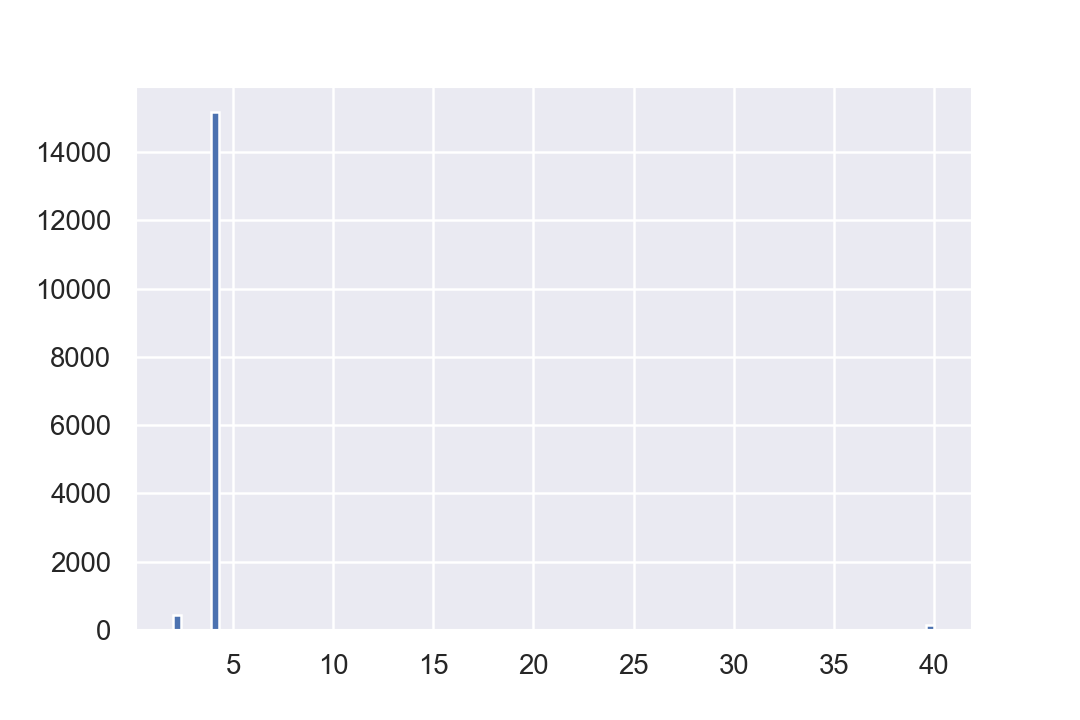

In [112]:
# Check class balance
plt.figure()
df.Class.hist(bins = 100)
plt.show()
# comment: very imbalaced results with mostly 4 i.e. benign. There are also some crazy numbers that shouldn't be in there. 

In [113]:
df.groupby('Class').ID.count()

Class
2.0       442
4.0     15162
20.0        5
40.0      151
Name: ID, dtype: int64

In [114]:
# comments: could 40 means 4 & 20 means 2? Perhaps the rows with these values are scaled up by x10? 
# Let's check by looking at the ratios of the means of 40 & 4 and 20 & 2. 
print(df[df.Class == 40].mean() / df[df.Class == 4].mean())
print(df[df.Class == 20].mean() / df[df.Class == 2].mean())

ID                              9.993595
Clump Thickness                 9.990976
Uniformity of Cell Size         9.568096
Uniformity of Cell Shape        9.448132
Marginal Adhesion              10.228496
Single Epithelial Cell Size    10.097656
Bare Nuclei                     9.439457
Bland Chromatin                 9.916050
Normal Nucleoli                 9.906796
Mitoses                        11.146667
Class                          10.000000
dtype: float64
ID                             11.109240
Clump Thickness                12.146565
Uniformity of Cell Size        12.235294
Uniformity of Cell Shape       11.297125
Marginal Adhesion              13.348993
Single Epithelial Cell Size     9.484979
Bare Nuclei                     8.899329
Bland Chromatin                10.558089
Normal Nucleoli                 9.505376
Mitoses                         9.384289
Class                          10.000000
dtype: float64


In [115]:
# seems that an extra '0' is added to every entry where Class is 20 or 40. Get rid of that. 
df[df.Class == 40] = df[df.Class == 40]/10
df[df.Class == 20] = df[df.Class == 20]/10

In [116]:
print('There are', sum(df.Class==4), 'benign records and', sum(df.Class==2),'malignant records.')
print('Their ratio is', round(sum(df.Class==4)/sum(df.Class==2),2), 'to 1')

There are 15313 benign records and 447 malignant records.
Their ratio is 34.26 to 1


In [117]:
# change the label of 4 & 2 to 0 & 1. 0 for benign, 1 for malignant.
df.Class[df.Class == 4] = 0 
df.Class[df.Class == 2] = 1

In [118]:
# save
df.to_csv(mypath+'Data/cleaned_df.csv')

In [119]:
#do pair plots of columns to see any correlation between values. Ignore Id column & color by Class
pair_plot = sns.pairplot(df.iloc[:,1:],hue="Class")
pair_plot.savefig(mypath+"Fig/pair_plot.png") # save this as it's large & slow to look at here
pari_plot.close()

<IPython.core.display.Javascript object>

NameError: name 'pari_plot' is not defined

In [120]:
df.describe()

,ID,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
count,1.576000e+04,15760.000000,15760.000000,15760.000000,15760.000000,15760.000000,15760.000000,15760.000000,15760.000000,15760.000000,15760.000000
mean,1.033640e+06,7.587373,6.893909,5.621827,5.034518,4.221383,6.462881,4.614150,4.971701,1.665736,0.028363
std,2.758336e+05,2.162884,2.466485,2.130135,2.909721,2.097088,3.222449,1.895932,2.816730,1.505560,0.166013
min,6.337500e+04,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,1.076352e+06,7.000000,5.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,1.000000,0.000000
50%,1.111249e+06,8.000000,6.000000,5.000000,4.000000,4.000000,8.000000,4.000000,5.000000,1.000000,0.000000
75%,1.198641e+06,10.000000,10.000000,7.000000,7.000000,4.000000,10.000000,7.000000,8.000000,2.000000,0.000000
max,1.345435e+07,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,1.000000


### Conclusions to initial EDA:
- data is highly imbalaced, with mostly benign records (34.26 benign to 1 malignant)
- all features have value between 1 & 10, however their mean and percentile distribution can vary a lot. 
    - For example, "Mitoses" has a mean around 1.7 and a 75% at 2. 
- didn't observe any obvious correlations between any pair of features, except btw "Uniformity of Cell Shape" & "Uniformity of Cell Size" (replotted below). There seems to be a positive correlation between the two, however, it's noisy.
- looking at the histogram of each feature, malignant records peak at left end of the histogram except for "mitoses"

<IPython.core.display.Javascript object>


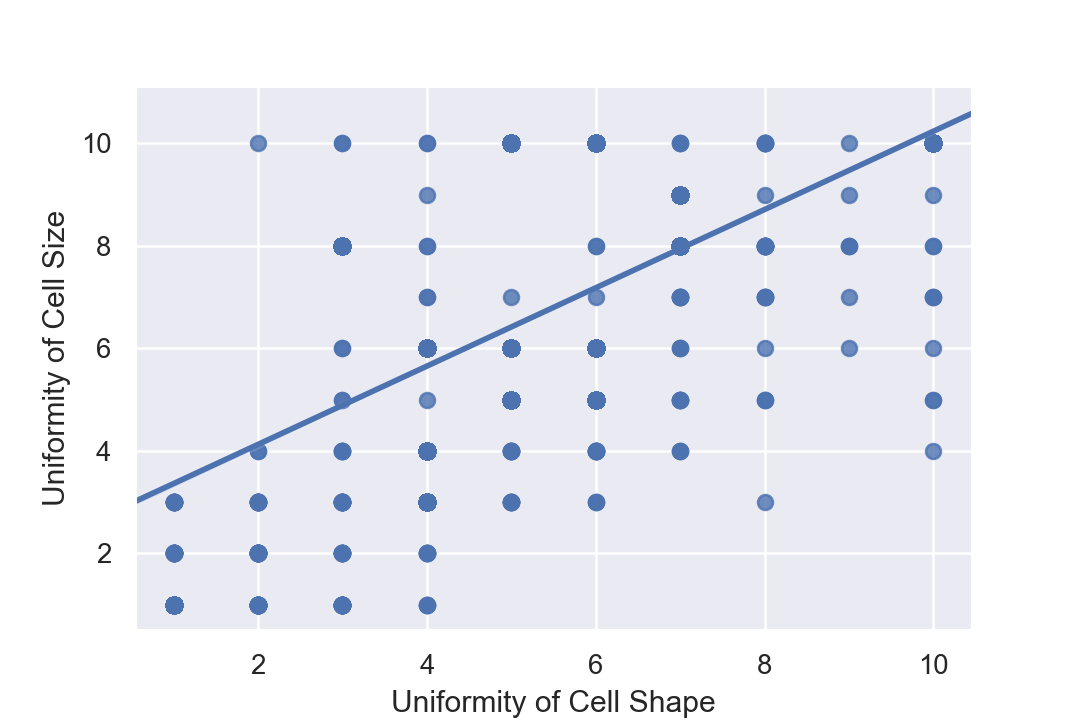

In [121]:
plt.figure()
sns.regplot(x="Uniformity of Cell Shape", y="Uniformity of Cell Size",data=df)
plt.show()